Single-Head Attention Model (Vanilla Attention)

Epoch 1/5: 100%|██████████| 6500/6500 [09:51<00:00, 10.98it/s, batch_loss=0.142] 


Epoch 1/5 - Train Acc: 0.8532


Epoch 2/5: 100%|██████████| 6500/6500 [09:07<00:00, 11.88it/s, batch_loss=0.314]  


Epoch 2/5 - Train Acc: 0.9241


Epoch 3/5: 100%|██████████| 6500/6500 [09:18<00:00, 11.65it/s, batch_loss=0.102]  


Epoch 3/5 - Train Acc: 0.9430


Epoch 4/5: 100%|██████████| 6500/6500 [09:15<00:00, 11.70it/s, batch_loss=0.105]  


Epoch 4/5 - Train Acc: 0.9542


Epoch 5/5: 100%|██████████| 6500/6500 [08:56<00:00, 12.11it/s, batch_loss=0.0869] 


Epoch 5/5 - Train Acc: 0.9612


Testing: 100%|██████████| 1625/1625 [00:01<00:00, 1543.89it/s]


              precision    recall  f1-score   support

           0       0.98      0.95      0.97     10400
           1       0.95      0.93      0.94     10400
           2       0.88      0.92      0.90     10400
           3       0.98      0.98      0.98     10400
           4       0.98      0.98      0.98     10400

    accuracy                           0.95     52000
   macro avg       0.95      0.95      0.95     52000
weighted avg       0.95      0.95      0.95     52000



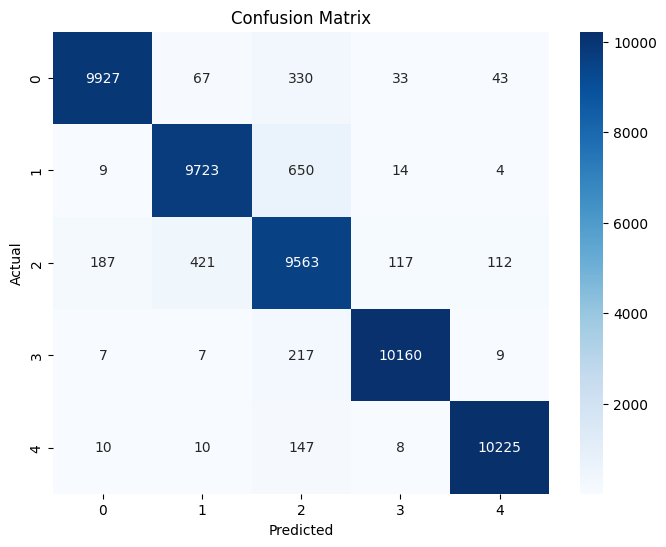

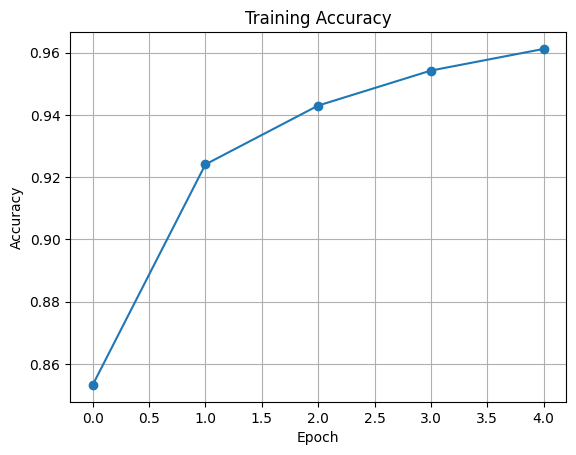

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")  # suppress warnings for cleaner output

# CONSTANTS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = r'D:\Research\Official Thesis NLP\16-7-25\thesis 2.csv'
MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-3
EMBED_DIM = 128

# Load and preprocess data
df = pd.read_csv(DATA_PATH)
texts = df['Text'].astype(str).tolist()
labels = df['Label'].astype(int).tolist()

# Build vocab
vocab = set(word for text in texts for word in text.lower().split())
word2idx = {w: i + 2 for i, w in enumerate(vocab)}
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1

def encode(text):
    tokens = text.lower().split()[:MAX_LEN]
    idxs = [word2idx.get(w, 1) for w in tokens]
    return idxs + [0] * (MAX_LEN - len(tokens))

X = [encode(t) for t in texts]
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, stratify=labels, random_state=42)

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, y_test), batch_size=BATCH_SIZE)

class SelfAttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.attn_weights = nn.Linear(embed_dim, 1)
        self.fc = nn.Linear(embed_dim, num_classes)
    def forward(self, x):
        emb = self.embedding(x)
        attn_scores = torch.softmax(self.attn_weights(emb).squeeze(-1), dim=1)
        context = torch.sum(attn_scores.unsqueeze(-1) * emb, dim=1)
        return self.fc(context)

model = SelfAttentionModel(len(word2idx), EMBED_DIM, len(set(labels))).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_accs = []

for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for X_batch, y_batch in pbar:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
        pbar.set_postfix({'batch_loss': loss.item()})
    acc = correct / total
    train_accs.append(acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {acc:.4f}")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in tqdm(test_loader, desc='Testing'):
        X_batch = X_batch.to(DEVICE)
        outputs = model(X_batch)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)

# Classification report: class-wise result
print(classification_report(y_true, y_pred))

# Confusion matrix visualization
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Training accuracy plot
plt.figure()
plt.plot(train_accs, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [3]:
import gc
import torch

# Empty CUDA cache if using GPU
torch.cuda.empty_cache()

# Force garbage collection (frees memory in RAM)
gc.collect()

# Optional: reset any global variables or lists (if you use them)
# For example:
# del model, optimizer, criterion
# model = None
# optimizer = None
# criterion = None


9362

Multi-Head Attention Model

Epoch 1 | Train Accuracy: 0.8810
Epoch 2 | Train Accuracy: 0.9536
Epoch 3 | Train Accuracy: 0.9716
Epoch 4 | Train Accuracy: 0.9794
Epoch 5 | Train Accuracy: 0.9839

Per-class classification report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     10400
           1       0.97      0.97      0.97     10400
           2       0.94      0.93      0.94     10400
           3       0.99      0.99      0.99     10400
           4       0.99      0.99      0.99     10400

    accuracy                           0.97     52000
   macro avg       0.97      0.97      0.97     52000
weighted avg       0.97      0.97      0.97     52000


Final Test Metrics:
Accuracy : 0.9730
Precision: 0.9729
Recall   : 0.9730
F1 Score : 0.9730
MAE      : 0.0407
MCC      : 0.9663
R² Score : 0.9641


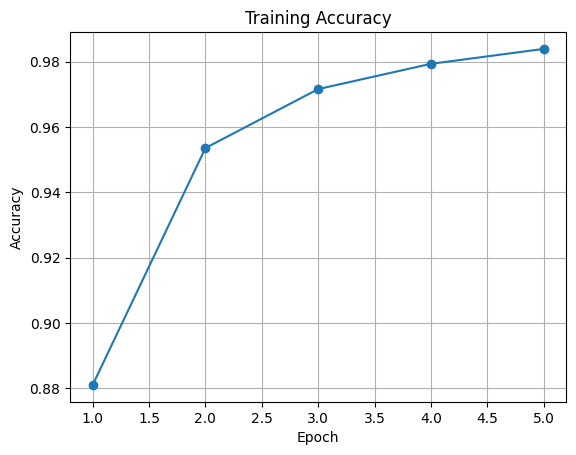

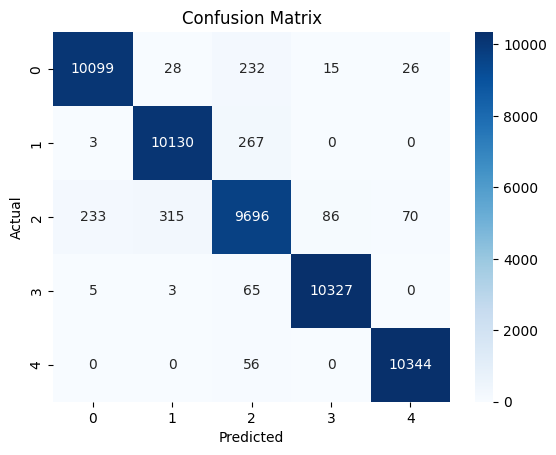

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    mean_absolute_error, matthews_corrcoef, r2_score, classification_report
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Device selection
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants
MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-3
DATA_PATH = r'D:\Research\Official Thesis NLP\16-7-25\thesis 2.csv'

# Load data
df = pd.read_csv(DATA_PATH)
texts = df['Text'].astype(str).tolist()
labels = df['Label'].astype(int).tolist()
num_classes = len(set(labels))

# Tokenizer and vocabulary
tokenizer = lambda x: x.lower().split()
vocab = {'<PAD>': 0, '<UNK>': 1}
for text in texts:
    for word in tokenizer(text):
        if word not in vocab:
            vocab[word] = len(vocab)

# Encode function
def encode(text, max_len):
    tokens = tokenizer(text)
    ids = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    ids = ids[:max_len] + [vocab['<PAD>']] * (max_len - len(ids))
    return ids

# Encode whole corpus
X = [encode(text, MAX_LEN) for text in texts]
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, stratify=labels, random_state=42
)

# Dataset class
class TextDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.inputs[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Data loaders
train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, y_test), batch_size=BATCH_SIZE)

# Multihead Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, T, E = x.size()

        Q = self.query(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-1, -2)) / (self.head_dim ** 0.5)
        attn_weights = torch.softmax(scores, dim=-1)
        context = torch.matmul(attn_weights, V)

        context = context.transpose(1, 2).contiguous().view(B, T, E)
        return self.fc_out(context)

# Model Class
class MultiHeadAttentionClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.attention = MultiHeadSelfAttention(embed_dim, num_heads)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        embed = self.embedding(x)           # [B, T, E]
        attn_out = self.attention(embed)    # [B, T, E]
        pooled = self.pool(attn_out.permute(0, 2, 1)).squeeze(-1)   # [B, E]
        out = self.fc(pooled)               # [B, num_classes]
        return out

# Instantiate model, optimizer, loss
model = MultiHeadAttentionClassifier(
    len(vocab), embed_dim=128, num_heads=4, num_classes=num_classes
).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# Training loop
train_acc_list = []

for epoch in range(EPOCHS):
    model.train()
    total_correct, total = 0, 0
    for batch in train_loader:
        inputs = batch['input_ids'].to(DEVICE)
        labels = batch['label'].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total += labels.size(0)
    acc = total_correct / total
    train_acc_list.append(acc)
    print(f"Epoch {epoch+1} | Train Accuracy: {acc:.4f}")

# Testing and evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['input_ids'].to(DEVICE)
        labels = batch['label'].to(DEVICE)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification report (per class breakdown)
print("\nPer-class classification report:")
print(classification_report(y_true, y_pred))

# Aggregate metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
mae = mean_absolute_error(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print("\nFinal Test Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"MAE      : {mae:.4f}")
print(f"MCC      : {mcc:.4f}")
print(f"R² Score : {r2:.4f}")

# Training accuracy plot
plt.plot(range(1, EPOCHS + 1), train_acc_list, marker='o')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [6]:
import gc
import torch

# Empty CUDA cache if using GPU
torch.cuda.empty_cache()

# Force garbage collection (frees memory in RAM)
gc.collect()

# Optional: reset any global variables or lists (if you use them)
# For example:
# del model, optimizer, criterion
# model = None
# optimizer = None
# criterion = None


9429

Attention + Lstm

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    mean_absolute_error, r2_score, matthews_corrcoef, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# =====================
# SETTINGS
# =====================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = r'D:\Research\Official Thesis NLP\16-7-25\thesis 2.csv'
MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-3
EMBED_DIM = 128
HIDDEN_DIM = 128  # hidden size for LSTM

# =====================
# LOAD DATA
# =====================
df = pd.read_csv(DATA_PATH)
texts = df['Text'].astype(str).tolist()
labels = df['Label'].astype(int).tolist()

# =====================
# VOCAB + TOKENIZER
# =====================
vocab = set(word for text in texts for word in text.lower().split())
word2idx = {w: i + 2 for i, w in enumerate(vocab)}
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1

def encode(text):
    tokens = text.lower().split()
    idxs = [word2idx.get(w, 1) for w in tokens[:MAX_LEN]]
    idxs += [0] * (MAX_LEN - len(idxs))
    return idxs

X = [encode(t) for t in texts]
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, stratify=labels, random_state=42
)

# =====================
# DATASET CLASS
# =====================
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, y_test), batch_size=BATCH_SIZE)

# =====================
# MODEL: Attention + LSTM
# =====================
class AttentionLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        emb = self.embedding(x)        # [batch, seq_len, embed_dim]
        lstm_out, (h, c) = self.lstm(emb)  # [batch, seq_len, hidden_dim]
        attn_scores = torch.softmax(self.attn(lstm_out).squeeze(-1), dim=1)   # [batch, seq_len]
        context = torch.sum(attn_scores.unsqueeze(-1) * lstm_out, dim=1)      # [batch, hidden_dim]
        return self.fc(context)

# =====================
# TRAINING SETUP
# =====================
model = AttentionLSTM(
    vocab_size=len(word2idx),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=len(set(labels))
).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_accs = []

# =====================
# TRAIN LOOP (with tqdm)
# =====================
for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    acc = correct / total
    train_accs.append(acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {acc:.4f}")

# =====================
# EVALUATION
# =====================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        outputs = model(X_batch)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)

print("\nPer-class classification report:")
print(classification_report(y_true, y_pred))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
mcc = matthews_corrcoef(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"MCC            : {mcc:.4f}")
print(f"MAE            : {mae:.4f}")
print(f"R² Score       : {r2:.4f}")

# =====================
# PLOTS
# =====================
plt.plot(train_accs, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Epoch 1/5: 100%|██████████| 6500/6500 [10:34<00:00, 10.25it/s]


Epoch 1/5 - Train Acc: 0.8843


Epoch 2/5: 100%|██████████| 6500/6500 [12:19<00:00,  8.79it/s]


Epoch 2/5 - Train Acc: 0.9704


Epoch 3/5:   8%|▊         | 544/6500 [01:10<13:09,  7.54it/s]

In [ ]:
import gc
import torch

# Empty CUDA cache if using GPU
torch.cuda.empty_cache()

# Force garbage collection (frees memory in RAM)
gc.collect()

# Optional: reset any global variables or lists (if you use them)
# For example:
# del model, optimizer, criterion
# model = None
# optimizer = None
# criterion = None


CNN + Attention

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    mean_absolute_error, r2_score, matthews_corrcoef, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# =====================
# SETTINGS
# =====================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = r'D:\Research\Official Thesis NLP\16-7-25\thesis 2.csv'  # Updated path
MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-3
EMBED_DIM = 128
NUM_FILTERS = 100
KERNEL_SIZE = 3

# =====================
# LOAD DATA
# =====================
df = pd.read_csv(DATA_PATH)
texts = df['Text'].astype(str).tolist()
labels = df['Label'].astype(int).tolist()

# =====================
# VOCAB + TOKENIZER
# =====================
vocab = set(word for text in texts for word in text.lower().split())
word2idx = {w: i + 2 for i, w in enumerate(vocab)}
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1

def encode(text):
    return [word2idx.get(w, 1) for w in text.lower().split()[:MAX_LEN]] + \
           [0] * (MAX_LEN - len(text.lower().split()[:MAX_LEN]))

X = [encode(t) for t in texts]
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, stratify=labels, random_state=42
)

# =====================
# DATASET CLASS
# =====================
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, y_test), batch_size=BATCH_SIZE)

# =====================
# MODEL: CNN + Attention
# =====================
class CNNAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_filters, kernel_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.conv = nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.attn = nn.Linear(num_filters, 1)
        self.fc = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        emb = self.embedding(x)                # [batch, seq_len, embed_dim]
        emb = emb.permute(0, 2, 1)             # [batch, embed_dim, seq_len]
        conv_out = torch.relu(self.conv(emb))  # [batch, num_filters, seq_len]
        conv_out = conv_out.permute(0, 2, 1)   # [batch, seq_len, num_filters]
        attn_scores = torch.softmax(self.attn(conv_out).squeeze(-1), dim=1)   # [batch, seq_len]
        context = torch.sum(attn_scores.unsqueeze(-1) * conv_out, dim=1)      # [batch, num_filters]
        return self.fc(context)

# =====================
# TRAINING SETUP
# =====================
model = CNNAttention(
    vocab_size=len(word2idx),
    embed_dim=EMBED_DIM,
    num_filters=NUM_FILTERS,
    kernel_size=KERNEL_SIZE,
    num_classes=len(set(labels))
).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_accs = []

# =====================
# TRAIN LOOP (with tqdm)
# =====================
for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    acc = correct / total
    train_accs.append(acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {acc:.4f}")

# =====================
# EVALUATION
# =====================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        outputs = model(X_batch)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)

print("\nPer-class classification report:")
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
mcc = matthews_corrcoef(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"MCC            : {mcc:.4f}")
print(f"MAE            : {mae:.4f}")
print(f"R² Score       : {r2:.4f}")

# =====================
# PLOTS
# =====================
plt.plot(train_accs, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import gc
import torch

# Empty CUDA cache if using GPU
torch.cuda.empty_cache()

# Force garbage collection (frees memory in RAM)
gc.collect()

# Optional: reset any global variables or lists (if you use them)
# For example:
# del model, optimizer, criterion
# model = None
# optimizer = None
# criterion = None


GRU + Attention

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    mean_absolute_error, r2_score, matthews_corrcoef, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# =====================
# SETTINGS
# =====================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = r'D:\Thesis\16-7-25\thesis 2.csv'
MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-3
EMBED_DIM = 128
HIDDEN_DIM = 128  # hidden size for GRU

# =====================
# LOAD DATA
# =====================
df = pd.read_csv(DATA_PATH)
texts = df['Text'].astype(str).tolist()
labels = df['Label'].astype(int).tolist()

# =====================
# VOCAB + TOKENIZER
# =====================
vocab = set(word for text in texts for word in text.lower().split())
word2idx = {w: i + 2 for i, w in enumerate(vocab)}
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1

def encode(text):
    return [word2idx.get(w, 1) for w in text.lower().split()[:MAX_LEN]] + \
           [0] * (MAX_LEN - len(text.lower().split()[:MAX_LEN]))

X = [encode(t) for t in texts]
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, stratify=labels, random_state=42
)

# =====================
# DATASET CLASS
# =====================
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, y_test), batch_size=BATCH_SIZE)

# =====================
# MODEL: GRU + Attention
# =====================
class GRUAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        emb = self.embedding(x)                  # [batch, seq_len, embed_dim]
        gru_out, h = self.gru(emb)               # [batch, seq_len, hidden_dim]
        attn_scores = torch.softmax(self.attn(gru_out).squeeze(-1), dim=1) # [batch, seq_len]
        context = torch.sum(attn_scores.unsqueeze(-1) * gru_out, dim=1)    # [batch, hidden_dim]
        return self.fc(context)

# =====================
# TRAINING SETUP
# =====================
model = GRUAttention(
    vocab_size=len(word2idx),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=len(set(labels))
).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_accs = []

# =====================
# TRAIN LOOP (with tqdm)
# =====================
for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    acc = correct / total
    train_accs.append(acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {acc:.4f}")

# =====================
# EVALUATION
# =====================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        outputs = model(X_batch)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)

print("\nPer-class classification report:")
print(classification_report(y_true, y_pred))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
mcc = matthews_corrcoef(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"MCC            : {mcc:.4f}")
print(f"MAE            : {mae:.4f}")
print(f"R² Score       : {r2:.4f}")

# =====================
# PLOTS
# =====================
plt.plot(train_accs, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import gc
import torch

# Empty CUDA cache if using GPU
torch.cuda.empty_cache()

# Force garbage collection (frees memory in RAM)
gc.collect()

# Optional: reset any global variables or lists (if you use them)
# For example:
# del model, optimizer, criterion
# model = None
# optimizer = None
# criterion = None


BiLSTM + Attention

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    mean_absolute_error, r2_score, matthews_corrcoef, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# =====================
# SETTINGS
# =====================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = r'D:\Thesis\16-7-25\thesis 2.csv'
MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-3
EMBED_DIM = 128
HIDDEN_DIM = 128  # hidden size per direction for BiLSTM!

# =====================
# LOAD DATA
# =====================
df = pd.read_csv(DATA_PATH)
texts = df['Text'].astype(str).tolist()
labels = df['Label'].astype(int).tolist()

# =====================
# VOCAB + TOKENIZER
# =====================
vocab = set(word for text in texts for word in text.lower().split())
word2idx = {w: i + 2 for i, w in enumerate(vocab)}
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1

def encode(text):
    return [word2idx.get(w, 1) for w in text.lower().split()[:MAX_LEN]] + \
           [0] * (MAX_LEN - len(text.lower().split()[:MAX_LEN]))

X = [encode(t) for t in texts]
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, test_size=0.2, stratify=labels, random_state=42
)

# =====================
# DATASET CLASS
# =====================
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, y_test), batch_size=BATCH_SIZE)

# =====================
# MODEL: BiLSTM + Attention
# =====================
class BiLSTMAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        emb = self.embedding(x)                        # [batch, seq_len, embed_dim]
        lstm_out, (h, c) = self.bilstm(emb)            # [batch, seq_len, hidden_dim*2]
        attn_scores = torch.softmax(self.attn(lstm_out).squeeze(-1), dim=1)   # [batch, seq_len]
        context = torch.sum(attn_scores.unsqueeze(-1) * lstm_out, dim=1)      # [batch, hidden_dim*2]
        return self.fc(context)

# =====================
# TRAINING SETUP
# =====================
model = BiLSTMAttention(
    vocab_size=len(word2idx),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=len(set(labels))
).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_accs = []

# =====================
# TRAIN LOOP (with tqdm)
# =====================
for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    acc = correct / total
    train_accs.append(acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {acc:.4f}")

# =====================
# EVALUATION
# =====================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        outputs = model(X_batch)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)

print("\nPer-class classification report:")
print(classification_report(y_true, y_pred))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
mcc = matthews_corrcoef(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"MCC            : {mcc:.4f}")
print(f"MAE            : {mae:.4f}")
print(f"R² Score       : {r2:.4f}")

# =====================
# PLOTS
# =====================
plt.plot(train_accs, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import gc
import torch

# Empty CUDA cache if using GPU
torch.cuda.empty_cache()

# Force garbage collection (frees memory in RAM)
gc.collect()

# Optional: reset any global variables or lists (if you use them)
# For example:
# del model, optimizer, criterion
# model = None
# optimizer = None
# criterion = None


BERT + Attention

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    mean_absolute_error, r2_score, matthews_corrcoef, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import BertTokenizer, BertModel
from torch.optim import AdamW

# =====================
# SETTINGS
# =====================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = r'D:\Thesis\16-7-25\thesis 2.csv'
MAX_LEN = 100
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5
PRE_TRAINED_MODEL = "bert-base-uncased"

# =====================
# LOAD DATA
# =====================
df = pd.read_csv(DATA_PATH)
texts = df['Text'].astype(str).tolist()
labels = df['Label'].astype(int).tolist()

# =====================
# TOKENIZER (BERT)
# =====================
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

def encode(texts, tokenizer, max_len=MAX_LEN):
    encodings = tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return encodings['input_ids'], encodings['attention_mask']

input_ids, attention_masks = encode(texts, tokenizer, MAX_LEN)
labels = torch.tensor(labels)

X_train, X_test, attn_train, attn_test, y_train, y_test = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, stratify=labels, random_state=42
)

# =====================
# DATASET CLASS
# =====================
class TextDataset(Dataset):
    def __init__(self, ids, mask, labels):
        self.ids = ids
        self.mask = mask
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        return self.ids[idx], self.mask[idx], self.labels[idx]

train_loader = DataLoader(TextDataset(X_train, attn_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, attn_test, y_test), batch_size=BATCH_SIZE)

# =====================
# MODEL: BERT + Attention
# =====================
class BERTAttention(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained(pretrained_model)
        hidden_size = self.bert.config.hidden_size
        self.attn = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        attn_scores = torch.softmax(self.attn(last_hidden_state).squeeze(-1), dim=1)
        context = torch.sum(attn_scores.unsqueeze(-1) * last_hidden_state, dim=1)
        return self.fc(context)

# =====================
# TRAINING SETUP
# =====================
num_classes = len(set(labels.numpy()))
model = BERTAttention(PRE_TRAINED_MODEL, num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR)
train_accs = []

# =====================
# TRAIN LOOP (with tqdm)
# =====================
for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    for ids, mask, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        ids, mask, y_batch = ids.to(DEVICE), mask.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(ids, mask)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    acc = correct / total
    train_accs.append(acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {acc:.4f}")

# =====================
# EVALUATION
# =====================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for ids, mask, y_batch in test_loader:
        ids, mask = ids.to(DEVICE), mask.to(DEVICE)
        outputs = model(ids, mask)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)

print("\nPer-class classification report:")
print(classification_report(y_true, y_pred))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
mcc = matthews_corrcoef(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"MCC            : {mcc:.4f}")
print(f"MAE            : {mae:.4f}")
print(f"R² Score       : {r2:.4f}")

# =====================
# PLOTS
# =====================
plt.plot(train_accs, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
import gc
import torch

# Empty CUDA cache if using GPU
torch.cuda.empty_cache()

# Force garbage collection (frees memory in RAM)
gc.collect()

# Optional: reset any global variables or lists (if you use them)
# For example:
# del model, optimizer, criterion
# model = None
# optimizer = None
# criterion = None


 TinyBERT + Attention

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    mean_absolute_error, r2_score, matthews_corrcoef, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW

# =====================
# SETTINGS
# =====================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = r'D:\Thesis\16-7-25\thesis 2.csv'
MAX_LEN = 100
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5
PRE_TRAINED_MODEL = "huawei-noah/TinyBERT_General_4L_312D"

# =====================
# LOAD DATA
# =====================
df = pd.read_csv(DATA_PATH)
texts = df['Text'].astype(str).tolist()
labels = df['Label'].astype(int).tolist()

# =====================
# TOKENIZER (TinyBERT)
# =====================
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL)

def encode(texts, tokenizer, max_len=MAX_LEN):
    encodings = tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return encodings['input_ids'], encodings['attention_mask']

input_ids, attention_masks = encode(texts, tokenizer, MAX_LEN)
labels = torch.tensor(labels, dtype=torch.long)

X_train, X_test, attn_train, attn_test, y_train, y_test = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, stratify=labels, random_state=42
)

# =====================
# DATASET CLASS
# =====================
class TextDataset(Dataset):
    def __init__(self, ids, mask, labels):
        self.ids = ids
        self.mask = mask
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        return self.ids[idx], self.mask[idx], self.labels[idx]

train_loader = DataLoader(TextDataset(X_train, attn_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, attn_test, y_test), batch_size=BATCH_SIZE)

# =====================
# MODEL: TinyBERT + Attention
# =====================
class TinyBERTAttention(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model)
        hidden_size = self.bert.config.hidden_size  # 312 for TinyBERT
        self.attn = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # [batch, seq_len, hidden_dim]
        attn_scores = torch.softmax(self.attn(last_hidden_state).squeeze(-1), dim=1)   # [batch, seq_len]
        context = torch.sum(attn_scores.unsqueeze(-1) * last_hidden_state, dim=1)      # [batch, hidden_dim]
        return self.fc(context)

# =====================
# TRAINING SETUP
# =====================
num_classes = len(set(labels.tolist()))
model = TinyBERTAttention(PRE_TRAINED_MODEL, num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR)
train_accs = []

# =====================
# TRAIN LOOP (with tqdm)
# =====================
for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    for ids, mask, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        ids, mask, y_batch = ids.to(DEVICE), mask.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(ids, mask)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    acc = correct / total
    train_accs.append(acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {acc:.4f}")

# =====================
# EVALUATION
# =====================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for ids, mask, y_batch in test_loader:
        ids, mask = ids.to(DEVICE), mask.to(DEVICE)
        outputs = model(ids, mask)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)

print("\nPer-class classification report:")
print(classification_report(y_true, y_pred))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
mcc = matthews_corrcoef(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"MCC            : {mcc:.4f}")
print(f"MAE            : {mae:.4f}")
print(f"R² Score       : {r2:.4f}")

# =====================
# PLOTS
# =====================
plt.plot(train_accs, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
import gc
import torch

# Empty CUDA cache if using GPU
torch.cuda.empty_cache()

# Force garbage collection (frees memory in RAM)
gc.collect()

# Optional: reset any global variables or lists (if you use them)
# For example:
# del model, optimizer, criterion
# model = None
# optimizer = None
# criterion = None


DistilBERT + Attention Head

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    mean_absolute_error, r2_score, matthews_corrcoef, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import DistilBertTokenizer, DistilBertModel
from torch.optim import AdamW

# =====================
# SETTINGS
# =====================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = r"D:\Thesis\16-7-25\thesis 2.csv"
MAX_LEN = 100
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5
MODEL_NAME = "distilbert-base-uncased"

# =====================
# LOAD DATA
# =====================
df = pd.read_csv(DATA_PATH)
texts = df["Text"].astype(str).tolist()
labels = df["Label"].astype(int).tolist()
num_classes = len(set(labels))

# =====================
# TOKENIZER
# =====================
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

def encode(texts, tokenizer, max_len=MAX_LEN):
    encodings = tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return encodings["input_ids"], encodings["attention_mask"]

input_ids, attention_masks = encode(texts, tokenizer, MAX_LEN)
labels = torch.tensor(labels, dtype=torch.long)  # Ensure labels are long/int

# Train-test split
X_train, X_test, attn_train, attn_test, y_train, y_test = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, stratify=labels, random_state=42
)

# =====================
# DATASET CLASS
# =====================
class TextDataset(Dataset):
    def __init__(self, ids, mask, labels):
        self.ids = ids
        self.mask = mask
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        return self.ids[idx], self.mask[idx], self.labels[idx]

train_loader = DataLoader(TextDataset(X_train, attn_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, attn_test, y_test), batch_size=BATCH_SIZE)

# =====================
# MODEL: DistilBERT + Attention Head
# =====================
class DistilBERTAttention(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.bert = DistilBertModel.from_pretrained(pretrained_model)
        hidden_size = self.bert.config.hidden_size
        self.attn = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state   # [batch, seq_len, hidden_dim]
        attn_scores = torch.softmax(self.attn(last_hidden_state).squeeze(-1), dim=1)   # [batch, seq_len]
        context = torch.sum(attn_scores.unsqueeze(-1) * last_hidden_state, dim=1)      # [batch, hidden_dim]
        return self.fc(context)

# =====================
# TRAINING SETUP
# =====================
model = DistilBERTAttention(MODEL_NAME, num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR)
train_accs = []

# =====================
# TRAIN LOOP (with tqdm)
# =====================
for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    for ids, mask, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        ids, mask, y_batch = ids.to(DEVICE), mask.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(ids, mask)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    acc = correct / total
    train_accs.append(acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {acc:.4f}")

# =====================
# EVALUATION
# =====================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for ids, mask, y_batch in test_loader:
        ids, mask = ids.to(DEVICE), mask.to(DEVICE)
        outputs = model(ids, mask)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)

print("\nPer-class classification report:")
print(classification_report(y_true, y_pred))

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro")
rec = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
mcc = matthews_corrcoef(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"MCC            : {mcc:.4f}")
print(f"MAE            : {mae:.4f}")
print(f"R² Score       : {r2:.4f}")

# =====================
# PLOTS
# =====================
plt.plot(train_accs, marker="o")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
import gc
import torch

# Empty CUDA cache if using GPU
torch.cuda.empty_cache()

# Force garbage collection (frees memory in RAM)
gc.collect()

# Optional: reset any global variables or lists (if you use them)
# For example:
# del model, optimizer, criterion
# model = None
# optimizer = None
# criterion = None


RoBERTa + Attention

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error, r2_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaTokenizer, RobertaModel
from torch.optim import AdamW
# =====================
# SETTINGS
# =====================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = r"D:\Thesis\16-7-25\thesis 2.csv"
MAX_LEN = 100
BATCH_SIZE = 16
EPOCHS = 3
LR = 2e-5
MODEL_NAME = "roberta-base"   # can also try "roberta-large"

# =====================
# LOAD DATA
# =====================
df = pd.read_csv(DATA_PATH)
texts = df["Text"].astype(str).tolist()
labels = df["Label"].astype(int).tolist()
num_classes = len(set(labels))

# =====================
# TOKENIZER
# =====================
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

def encode(texts, tokenizer, max_len=MAX_LEN):
    encodings = tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return encodings["input_ids"], encodings["attention_mask"]

input_ids, attention_masks = encode(texts, tokenizer, MAX_LEN)
labels = torch.tensor(labels)

X_train, X_test, attn_train, attn_test, y_train, y_test = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, stratify=labels, random_state=42
)

# =====================
# DATASET CLASS
# =====================
class TextDataset(Dataset):
    def __init__(self, ids, mask, labels):
        self.ids = ids
        self.mask = mask
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        return self.ids[idx], self.mask[idx], self.labels[idx]

train_loader = DataLoader(TextDataset(X_train, attn_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, attn_test, y_test), batch_size=BATCH_SIZE)

# =====================
# MODEL: RoBERTa + Attention
# =====================
class RoBERTaAttention(nn.Module):
    def __init__(self, pretrained_model, num_classes):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(pretrained_model)

        hidden_size = self.roberta.config.hidden_size  # 768 for base, 1024 for large
        self.attn = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state   # [batch, seq_len, hidden_dim]

        # Attention pooling
        attn_scores = torch.softmax(self.attn(last_hidden_state).squeeze(-1), dim=1)   # [batch, seq_len]
        context = torch.sum(attn_scores.unsqueeze(-1) * last_hidden_state, dim=1)      # [batch, hidden_dim]

        return self.fc(context)

# =====================
# TRAINING SETUP
# =====================
model = RoBERTaAttention(MODEL_NAME, num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR)

train_accs = []

# =====================
# TRAIN LOOP
# =====================
for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    for ids, mask, y_batch in train_loader:
        ids, mask, y_batch = ids.to(DEVICE), mask.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(ids, mask)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    acc = correct / total
    train_accs.append(acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {acc:.4f}")

# =====================
# EVALUATION
# =====================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for ids, mask, y_batch in test_loader:
        ids, mask = ids.to(DEVICE), mask.to(DEVICE)
        outputs = model(ids, mask)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro")
rec = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
mcc = matthews_corrcoef(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"MCC            : {mcc:.4f}")
print(f"MAE            : {mae:.4f}")
print(f"R² Score       : {r2:.4f}")

# =====================
# PLOTS
# =====================
plt.plot(train_accs, marker="o")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
import gc
import torch

# Empty CUDA cache if using GPU
torch.cuda.empty_cache()

# Force garbage collection (frees memory in RAM)
gc.collect()

# Optional: reset any global variables or lists (if you use them)
# For example:
# del model, optimizer, criterion
# model = None
# optimizer = None
# criterion = None


BERT + HAN

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error, r2_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW

# =====================
# SETTINGS
# =====================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = r"D:\Thesis\16-7-25\thesis 2.csv"
MAX_LEN = 50         # per sentence
MAX_SENT = 10        # max sentences per document
BATCH_SIZE = 8
EPOCHS = 3
LR = 2e-5
MODEL_NAME = "bert-base-uncased"

# =====================
# LOAD DATA
# =====================
df = pd.read_csv(DATA_PATH)
texts = df["Text"].astype(str).tolist()
labels = df["Label"].astype(int).tolist()
num_classes = len(set(labels))

# =====================
# TOKENIZER
# =====================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def encode_document(doc, tokenizer, max_sent=MAX_SENT, max_len=MAX_LEN):
    # Split into sentences (simplified: split by ".")
    sentences = doc.split('.')[:max_sent]
    input_ids, attn_masks = [], []
    for sent in sentences:
        enc = tokenizer(
            sent,
            max_length=max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids.append(enc['input_ids'])
        attn_masks.append(enc['attention_mask'])
    # Pad to MAX_SENT sentences
    while len(input_ids) < max_sent:
        input_ids.append(torch.zeros((1, max_len), dtype=torch.long))
        attn_masks.append(torch.zeros((1, max_len), dtype=torch.long))
    return torch.cat(input_ids, dim=0), torch.cat(attn_masks, dim=0)

# Encode all docs
input_ids, attention_masks = [], []
for text in texts:
    ids, mask = encode_document(text, tokenizer, MAX_SENT, MAX_LEN)
    input_ids.append(ids.unsqueeze(0))
    attention_masks.append(mask.unsqueeze(0))

input_ids = torch.cat(input_ids, dim=0)           # [N, max_sent, max_len]
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Train-test split
X_train, X_test, attn_train, attn_test, y_train, y_test = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, stratify=labels, random_state=42
)

# =====================
# DATASET CLASS
# =====================
class HAN_Dataset(Dataset):
    def __init__(self, ids, masks, labels):
        self.ids = ids
        self.masks = masks
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        return self.ids[idx], self.masks[idx], self.labels[idx]

train_loader = DataLoader(HAN_Dataset(X_train, attn_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(HAN_Dataset(X_test, attn_test, y_test), batch_size=BATCH_SIZE)

# =====================
# WORD & SENTENCE ATTENTION
# =====================
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        # x: [batch, seq_len, hidden_dim]
        scores = torch.softmax(self.attn(x).squeeze(-1), dim=1)  # [batch, seq_len]
        context = torch.sum(scores.unsqueeze(-1) * x, dim=1)     # [batch, hidden_dim]
        return context

# =====================
# MODEL: BERT + HAN
# =====================
class BERT_HAN(nn.Module):
    def __init__(self, pretrained_model, num_classes, hidden_dim=256):
        super().__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model)
        bert_hidden = self.bert.config.hidden_size  # 768

        # Word-level attention
        self.word_attn = AttentionLayer(bert_hidden)

        # Sentence encoder (BiGRU/LSTM)
        self.sentence_encoder = nn.GRU(bert_hidden, hidden_dim, batch_first=True, bidirectional=True)

        # Sentence-level attention
        self.sentence_attn = AttentionLayer(hidden_dim*2)

        # Classifier
        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, doc_ids, doc_masks):
        """
        doc_ids: [batch, max_sent, max_len]
        doc_masks: [batch, max_sent, max_len]
        """
        batch_size, max_sent, max_len = doc_ids.size()
        sentence_vecs = []

        # Encode each sentence with BERT → word attention
        for i in range(max_sent):
            input_ids = doc_ids[:, i, :]       # [batch, max_len]
            attn_mask = doc_masks[:, i, :]     # [batch, max_len]

            outputs = self.bert(input_ids=input_ids, attention_mask=attn_mask)
            word_embeddings = outputs.last_hidden_state     # [batch, max_len, hidden]
            word_vector = self.word_attn(word_embeddings)   # [batch, hidden]
            sentence_vecs.append(word_vector)

        sentence_vecs = torch.stack(sentence_vecs, dim=1)    # [batch, max_sent, hidden]

        # Encode sentence sequence
        sent_enc, _ = self.sentence_encoder(sentence_vecs)   # [batch, max_sent, hidden*2]

        # Sentence attention
        doc_vec = self.sentence_attn(sent_enc)               # [batch, hidden*2]

        # Classify
        return self.fc(doc_vec)

# =====================
# TRAINING SETUP
# =====================
model = BERT_HAN(MODEL_NAME, num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR)

train_accs = []

# =====================
# TRAIN LOOP
# =====================
for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    for ids, mask, y_batch in train_loader:
        ids, mask, y_batch = ids.to(DEVICE), mask.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(ids, mask)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    acc = correct / total
    train_accs.append(acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {acc:.4f}")

# =====================
# EVALUATION
# =====================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for ids, mask, y_batch in test_loader:
        ids, mask = ids.to(DEVICE), mask.to(DEVICE)
        outputs = model(ids, mask)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro")
rec = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
mcc = matthews_corrcoef(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"MCC            : {mcc:.4f}")
print(f"MAE            : {mae:.4f}")
print(f"R² Score       : {r2:.4f}")

# =====================
# PLOTS
# =====================
plt.plot(train_accs, marker="o")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
import gc
import torch

# Empty CUDA cache if using GPU
torch.cuda.empty_cache()

# Force garbage collection (frees memory in RAM)
gc.collect()

# Optional: reset any global variables or lists (if you use them)
# For example:
# del model, optimizer, criterion
# model = None
# optimizer = None
# criterion = None


ELECTRA + HAN (Hierarchical Attention Network)

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, mean_absolute_error, r2_score, matthews_corrcoef
)
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW

# =====================
# SETTINGS
# =====================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = r"D:\Thesis\16-7-25\thesis 2.csv"   # <<== change path accordingly
MAX_LEN = 50         # per sentence
MAX_SENT = 10        # max sentences per document
BATCH_SIZE = 8
EPOCHS = 3
LR = 2e-5
MODEL_NAME = "google/electra-base-discriminator"   # ✅ ELECTRA

# =====================
# LOAD DATA
# =====================
df = pd.read_csv(DATA_PATH)
texts = df["Text"].astype(str).tolist()
labels = df["Label"].astype(int).tolist()
num_classes = len(set(labels))

# =====================
# TOKENIZER
# =====================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def encode_document(doc, tokenizer, max_sent=MAX_SENT, max_len=MAX_LEN):
    # Split into sentences (naive rule: split by ".")
    sentences = doc.split('.')[:max_sent]
    input_ids, attn_masks = [], []
    for sent in sentences:
        enc = tokenizer(
            sent,
            max_length=max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids.append(enc['input_ids'])
        attn_masks.append(enc['attention_mask'])
    # Pad up to MAX_SENT with empty sentences
    while len(input_ids) < max_sent:
        input_ids.append(torch.zeros((1, max_len), dtype=torch.long))
        attn_masks.append(torch.zeros((1, max_len), dtype=torch.long))
    return torch.cat(input_ids, dim=0), torch.cat(attn_masks, dim=0)

# Encode all docs
input_ids, attention_masks = [], []
for text in texts:
    ids, mask = encode_document(text, tokenizer, MAX_SENT, MAX_LEN)
    input_ids.append(ids.unsqueeze(0))
    attention_masks.append(mask.unsqueeze(0))

input_ids = torch.cat(input_ids, dim=0)           # [N, max_sent, max_len]
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Train-test split
X_train, X_test, attn_train, attn_test, y_train, y_test = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, stratify=labels, random_state=42
)

# =====================
# DATASET CLASS
# =====================
class HAN_Dataset(Dataset):
    def __init__(self, ids, masks, labels):
        self.ids = ids
        self.masks = masks
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        return self.ids[idx], self.masks[idx], self.labels[idx]

train_loader = DataLoader(HAN_Dataset(X_train, attn_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(HAN_Dataset(X_test, attn_test, y_test), batch_size=BATCH_SIZE)

# =====================
# ATTENTION LAYER
# =====================
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        # x: [batch, seq_len, hidden_dim]
        scores = torch.softmax(self.attn(x).squeeze(-1), dim=1)  # [batch, seq_len]
        context = torch.sum(scores.unsqueeze(-1) * x, dim=1)     # [batch, hidden_dim]
        return context

# =====================
# MODEL: ELECTRA + HAN
# =====================
class ELECTRA_HAN(nn.Module):
    def __init__(self, pretrained_model, num_classes, hidden_dim=256):
        super().__init__()
        # Load ELECTRA
        self.electra = AutoModel.from_pretrained(pretrained_model)
        electra_hidden = self.electra.config.hidden_size  # typically 768 for base

        # Word-level attention
        self.word_attn = AttentionLayer(electra_hidden)

        # Sentence encoder (BiGRU)
        self.sentence_encoder = nn.GRU(electra_hidden, hidden_dim, batch_first=True, bidirectional=True)

        # Sentence-level attention
        self.sentence_attn = AttentionLayer(hidden_dim*2)

        # Classifier
        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, doc_ids, doc_masks):
        """
        doc_ids: [batch, max_sent, max_len]
        doc_masks: [batch, max_sent, max_len]
        """
        batch_size, max_sent, max_len = doc_ids.size()
        sentence_vecs = []

        # Encode each sentence with ELECTRA → word attention
        for i in range(max_sent):
            input_ids = doc_ids[:, i, :]       # [batch, max_len]
            attn_mask = doc_masks[:, i, :]     # [batch, max_len]

            outputs = self.electra(input_ids=input_ids, attention_mask=attn_mask)
            word_embeddings = outputs.last_hidden_state     # [batch, max_len, hidden]
            word_vector = self.word_attn(word_embeddings)   # [batch, hidden]
            sentence_vecs.append(word_vector)

        sentence_vecs = torch.stack(sentence_vecs, dim=1)    # [batch, max_sent, hidden]

        # Encode sentence sequence with BiGRU
        sent_enc, _ = self.sentence_encoder(sentence_vecs)   # [batch, max_sent, hidden*2]

        # Sentence attention
        doc_vec = self.sentence_attn(sent_enc)               # [batch, hidden*2]

        # Classify
        return self.fc(doc_vec)

# =====================
# TRAINING SETUP
# =====================
model = ELECTRA_HAN(MODEL_NAME, num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR)

train_accs = []

# =====================
# TRAIN LOOP
# =====================
for epoch in range(EPOCHS):
    model.train()
    correct, total = 0, 0
    for ids, mask, y_batch in train_loader:
        ids, mask, y_batch = ids.to(DEVICE), mask.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(ids, mask)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    acc = correct / total
    train_accs.append(acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {acc:.4f}")

# =====================
# EVALUATION
# =====================
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for ids, mask, y_batch in test_loader:
        ids, mask = ids.to(DEVICE), mask.to(DEVICE)
        outputs = model(ids, mask)
        preds = outputs.argmax(1).cpu().numpy()
        y_true.extend(y_batch.numpy())
        y_pred.extend(preds)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro")
rec = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")
mcc = matthews_corrcoef(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\nTest Accuracy : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"MCC            : {mcc:.4f}")
print(f"MAE            : {mae:.4f}")
print(f"R² Score       : {r2:.4f}")

# =====================
# PLOTS
# =====================
plt.plot(train_accs, marker="o")
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()